In [1]:
# Libraries and stuff
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import IPython
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable



In [2]:
'''
Constants for discretizing states. There are 50 states of theta and thetadot each.
State 0 corresponds to theta = -pi, thetadot = -6.5m/s
State 2499 corresponds to theta = pi, thetadot = 6.5m/s
States [24, 25, 2474 and 2475] have values that approximately equal theta = -pi , thetadot = 0 
These 4 states are considered goal states.
'''
maxVelocity = 6.5
thetaStates = 50
thetaDotStates = 50
thetaStepSize = 2*math.pi/49
thetaDotStepSize = 2*maxVelocity/49

In [3]:
def pendulum(state,action):
    
    '''
    This function takes state(number from 0 to 2499 ) and action (0, 1 or 2) and computes the next state
    of the pendulum based on the action. 
    
    '''
    #constants
    GRAVITY = 9.8
    LENGTH = 1.0
    dt1 = 0.001
    FORCE = 4.0
    time = 200
    if (action == 0):
        u = -FORCE
    elif(action == 1):
        u = FORCE
    elif(action == 2):
        u = 0
    # Get values of theta and thetadot that correspond to the state
    theta, thetaDot = get_values(state)
    
    # Do Euler update of values for theta and thetadot to calculate the new theta and thetadot 
    for i in range(time):
        
        newThetaDot = thetaDot + dt1*(-(GRAVITY/LENGTH)*np.sin(theta) + u)
        newTheta = theta + dt1*newThetaDot
        
        theta = ((newTheta + np.pi)%(2*np.pi)) - np.pi
        thetaDot = np.clip(newThetaDot, -maxVelocity, maxVelocity)
    
    #Discretize the values theta and thetadot back into a state(number from 0 to 2499)
    next_state = get_state(newTheta, newThetaDot)
    return next_state
    

In [4]:
def get_state(theta, thetaDot):
    '''
    Discretize the values theta and thetadot back into a state(number from 0 to 2499)
    '''
    state = 0
    for i in range (thetaStates):
        for j in range (thetaDotStates):
            if ((theta >= (-np.pi + thetaStepSize*i)) & (thetaDot >=(-maxVelocity + thetaDotStepSize*j))):
                state = i*thetaStates + j    
    return state

def get_values(state):
    '''
    Get values of theta and thetadot that correspond to the state
    '''
    thetaDot = -maxVelocity + (state%thetaDotStates)*thetaDotStepSize
    theta = -np.pi + int(state/thetaStates)*thetaStepSize
    return theta, thetaDot

In [5]:
def draw_pendulum(theta_array):
    '''
    This function takes an array of theta values for each time instant and creates an animation. 
    
    '''
    x1 = np.sin(theta_array)
    y1 = -np.cos(theta_array)

    x1= x1[:,0::200]
    y1= y1[:,0::200]

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
    ax.grid()

    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

    dt = 0.0005
    t = np.arange(0.0, 20, dt)

    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text


    def animate(i):
        thisx = [0, x1[i]]
        thisy = [0, y1[i]]

        line.set_data(thisx, thisy)
        time_text.set_text(time_template % (i*dt))
        return line, time_text

    ani = animation.FuncAnimation(fig, animate, np.arange(1, len(theta_array)),
                                  interval=200, blit=True, init_func=init)


    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [6]:
# state transition table
def generate_next_state():
    
    '''
    This function makes a table of all possible states(rows) and 
    actions(columns) and records next state according to the pendulum dynamics.  
    '''
    next_states = np.zeros((thetaStates*thetaDotStates,3))
    for i in range (thetaStates*thetaDotStates):
        for j in range(3):
            next_states[i,j] = int(pendulum(i,j))
    #     print(next_states[i])
    return next_states

In [7]:
# A matrix with next states, next_state = next_states[state,action]. This table can be used
# to compute the next state of pendulum, given an action, at each step.
next_states = generate_next_state()
    

###  Defining Neural Network to store Q(s,a) 

In [8]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, H2, D_out = 1, 2, 32, 32, 1

# Create empty Tensor to hold input
x = torch.empty(1, 2)

# Use the nn package to define our model and loss function.
policy_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.Linear(H1, H2),
    torch.nn.Linear(H2, D_out),)

#target_net is used to freeze the target every few steps
target_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.Linear(H1, H2),
    torch.nn.Linear(H2, D_out),)


target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)


In [9]:
def run_episode():
    #hyperparameters and initial conditions for each episode
    currentState = 1225
    currentAct = 1.0
    episodeSteps = 500
    EPSILON = 0.25
    GAMMA = 0.999
    TARGET_UPDATE = 10
    Qa_values = np.zeros(3)
    Qa1_values = np.zeros(3)
    
    for i in range(episodeSteps):
        #get next state based on current state and current best action 
        nextState = next_states[int(currentState),int(currentAct)]
        
        # set the reward for current state
        if((currentState ==24)|(currentState ==25)|(currentState ==2474)|(currentState ==2475)):
            reward = 0
        else:
            reward = -1
        
        #######
        #evaluate Q(s,a) at current state and current best action from neural net
        x[0][0] = currentState
        x[0][1] = float(currentAct)
        state_action_values = policy_net(x)
        state_action_values.requires_grad_(True)
        #######
        
        #######
        #evaluate max_a(Q(s',a)) at current state and current best action from 'target' neural net 
        x[0][0] = nextState
        x[0][1] = 0
        Qa1_values[0] = target_net(x).detach()
        x[0][1] = 1
        Qa1_values[1] = target_net(x).detach()
        x[0][1] = 2
        Qa1_values[2] = target_net(x).detach()
        nextAct1 = np.argmax(Qa1_values)
        x[0][1] = float(nextAct1)
        next_state_values = target_net(x).detach()
        #######
        
        # Target value for our loss function
        expected_state_action_values = (next_state_values * GAMMA) + reward
        expected_state_action_values.requires_grad_(True)
        
        # Calculate loss
        loss = loss_fn(state_action_values, expected_state_action_values)
        loss = Variable(loss, requires_grad = True)
        
        # Update policy
        policy_net.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        ########
        # Best next action for next state, evaluated from our model, policy_net. 
        if (EPSILON > random.randint(1,10)*0.1):
            nextAct = np.array(random.randint(0,2))
        else:
            x[0][0] = nextState
            
            x[0][1] = 0
            Qa_values[0] = policy_net(x).detach()


            x[0][1] = 1
            Qa_values[1] = policy_net(x).detach()


            x[0][1] = 2
            Qa_values[2] = policy_net(x).detach()

            nextAct = np.argmax(Qa_values)
        ########
        
        
        #update state
        currentState = nextState
        currentAct = nextAct
        # Update the target network, copying all weights and biases in policy_net
        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
            

In [10]:
# Run episodes  
for i in range(1000):
    run_episode()


In [11]:
# Here I'm trying to get a sequence of actions from the model that has already learned.
# Start at the pendulum down position at state = 1225
St = 1225
NextValue = np.zeros((3,1))
policy = np.zeros((500,1))

# Get 500 steps from the trained model
# Get the best next step for each state by comparing all three state-action values.
# Store each step in policy 
for i in range(500):
    policy[i] = St

    x[0][0] = St
    x[0][1] = 0
    NextValue[0] = target_net(x).detach()
    print('val act 0',NextValue[0])
    
    x[0][1] = 1
    NextValue[1] = target_net(x).detach()
    print('val act 1',NextValue[1])
    
    x[0][1] = 2
    NextValue[2] = target_net(x).detach()
    print('val act 2',NextValue[2])
    
    nextAct = int(np.argmax(NextValue))
    print(nextAct)
    newState = next_states[St,nextAct]
    St = int(newState)
    
    

val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-23

val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-23

val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-23

val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2
val act 0 [-230.96757507]
val act 1 [-230.91448975]
val act 2 [-230.86140442]
2


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAg1m1kYXQAAAKtBgX//6ncRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49NSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNo
PTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFw
bWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAFMhliIQA
FP/+98dPwKbo+WbLnUU9ITCK2PpIKL1Y7NAydQAAAwAARMD9n/7PvX4gJ4mVoMNs+cmuVU5lHW1w
tpoNC79s7jKsKRaLWCfGNMEFH3yXNmUDw9qEyYkFk8xiMF/I3+qDUYrgnkQABnaG8G15Dhwy4ryI
lPbpCTsVrOWZTOGVrNv10ijPOire960r9znhlOUc/NRIWochbxHKSEOx9WKpF3zmJr9jaeGKj3+J
0/fYDp/J2Dl+GPnvu8Zx9PtSqKeDxSRG6KHrEkdnWRGifzcV/8E5gvfdKb2059D9KKLNPVLaOGX3
EslwRHEXpgVYf71DBBgf8MFyBppl6G2P4HmO64G+1WAhgwkSLTbz/iGd/WuKP9VoS1ReMZYjSZv9
FD0Z0vz+erjm6qQCzjK7fHddFqBYKr1j/eoXV4RrtY0V+pqd6NprGMNlVhUUgEHCYTX/XvIjRYfy
qxSEfdCu4Dj+614lq90I0Ivi++/GxujaFnbe8nBQhIVLmgPdfCd8xrKYnD/DLijBkiJJQFkR9GvN
kIt1RLCAfMHE78UR0iTGM3OjLp6xegdj1JjmgkNjbm43DoE100KT3qBHSaQUD1riGz7djgAW0RMS
xF6FdpMLSUOiuWSGZzD6wH3azArlzHCrl8eKdz4BbL/22ImZFyq31IDM71KjfOqhZG+Aq3eZUtVQ
WUANZyJ934P4AJ6ed9C0mpu6RQ4DuBs8BUP8+x4T0ZCpHA+pIULbbjCB1kYbImtKDf5mFQ1BUrrv
ZGbryqSCgS3Ou8u1Hx1lIWPUdPFWQiQGuwfHvEaATkMqnmTmZ1v2WaR9G4oq3kNVpiCRnq4Wv7DV
urHA56RcpuNg4k+mRkKbfdDJiNBwvS9MOUJx+B3dFeiQWsS7BVNQe5v7lP9MB9UcMnwRuQ9x91dj
8BrrkCGUiRonstVU6Xb9ixqlRfanhdXq2pnA9ArGnwi2XPDeCTfFp+oWGJj9ycrY+LoBPRyuUrmW
6dicmuQ36XW21NmF8QkOZwVpFWGBJuIteSnejJz2IT2M8BT94xZd67YE7eNgvnWEomiDiwcPMx2F
e+8CEhE+0ZIe7rxH/iZ+aL/FPPTc7YXP+i6SGOxOWapXDliuYGk7aKeTAb0KBxqnRwzNEU5qHPSd
70OxwTikwFlcKBB6UEmxbFbP///KFcGHzhXQyZCrKpkoLqE1pzfWo96PCEzFjOkRXx8UWDb//82L
osY3e5Xzh9OLNaa2JlifGm9O/p/CvAmVU0dhU8FxpGvnyQ+XEkQ3FPovRfbfkbfBthjxFerFufQ9
pzrG+XgMA9OGAE28pAfrn+56FKuRO4/Fa76Zn11F07uJls1sRyC9B/YOioz5tvmb+iH9Trwnd8z5
AaaU518RnE7b2qmQCwnGpPy2BxDfazqTeeO3HAhdo4zdtWDQN2aPGEKpAcKZoJ567ENzg2vVhdaD
m4nLD6wGvF7DlLQTdAN2xJToboIx0ApMynGVmItB5AkEB6d2L1cFtUCyjEgN6ko1gM1NP8vPZcp0
3SZfwaQhJrY5SK59FARcHLBEr2xyARLoNz7T/YJxhPWjj1hMGbRCWoNH9wE2Rq/21o3zpH2Kdshv
f17v4dngA36KqA95qTrhHUZqO26M0t6nuLO6B5LykO5yZsf8AdS9fVSmdGHPr/KVH2cvO4izrs+6
VnsVFZ3v/yJ5//6iOoyJMDO+XlnqacjYTbawjHO7rPNJXrQs2e46ULpyQl/h5bO//f3d2h5sFNWF
JN3+Tk1l7KEg6LzkyTgAACiy++Lnj3bNvDqTgafQwPLVyn2NJG2l5wYDDQU/jaMsemlyASD11Lph
+E6mSI2dOIQM/3wbrgtqge+cvpNZb9eRslMOdTHiP7d5LiPoIMv2kokkXAxkxz6cFEr+KtNCN58t
tZUawP+BAyt0Qt3XmYnA5ieumdfx6xnp/Ioe03XNLwpoY7Pp+7LdckvwztDuOpe2BDbMGu6Es4P0
L5VXFWcdBn5Lxyz1M+Gy/v7LJpfoaJ/RLjPupZAElywK92sLps1eigi2nc/UD2/jErCyCSuT10h4
XpuSg6o3S4Ehc7Xnf/u+s+t7oZUZ6IARmLBNDebHyjPSmJg4jsQDHCWdGvDPgabToQj5/7YSdrT3
Hw1RS7ccwaS4m/wTVkHF4sPtVpyfidYFUDwHwvloh4As9MGpEgHu//tsmVNbgxdmu3LFRQYnH9oW
TPnVoIc34dq3og/flPplM/txgeppwL9tsgGECOEfIwsZARZDkJuPzg7doLIvhtRAJ6yC81TeryH/
fRfn/J2cmiE3RHR+Nqq+623BpDLtIOfhhMnjmO9BtvHvmkrZZNW0WIsISIier699NwXA6/391UO3
NqaFB1fjXx8zj7Zip7//cB/sp7AAnVvGyH4Nm7/41EWmlDC4gKpqaE5JnFw9xEG5uK0Ej7PYHx+e
6oLfP+dVhhtp3AM0DIbEuhzpExbBpZXQwccIjm/tPRruBjI/ct+jO3lIAfeLItjHGL7uThtUJXIm
r//1RGjp+RsYyA+Wr4aGB9sgPTKZTH+ijR8AWj1f6WuKsk1IVv/aVHv6nZOp9oHL8icOQVuolunc
FKVSMqMHmnK3rVLgpDmdn2sV/qr6ydj9jZyj1qO1JicFAR07e7OlvMtRPpM8yjB/0eRmUE/ga9xt
jsBGyjP+bhDwAKPgqhyax3pWai+AqqX+JC2kg5N81oA5sF0GCcHl/RbhCQX+CXfJ9ybhnJiOCTR8
dhlOwmc+oN4YXW8G9mgnGJ5403hFVecs2/+//TfDuMP7aAxPSDq4H35OZkB8VHbDA3mgEqR2u1GJ
SZjPiqNGVB3MOfjqMe5t1oompAWV2Tujxz+3S+UW/ogjSuIInpwtGEuKxlbcUZG1JSWCFuXwOa5J
T9Iu2d4JUi8tJwdlTV9Qk

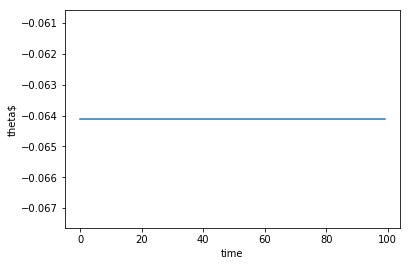

In [12]:
# Plot the policy
thetaVals = np.zeros((100,1))
for i in range(100):
    
    st = policy[i]
    thetaVals[i],_ = get_values(st)
    
    
plt.plot(range(100), thetaVals)
draw_pendulum(thetaVals)
plt.xlabel("time")
plt.ylabel("theta$")
plt.show()

In [13]:
def freependulum(state):
    '''
    To check dynamics of pendulum without control. 
    This function takes a state value from 0 to 2499 and displays SHM of pendulum with 0 force.  
    '''
    freeswing = np.zeros([100,1])
    freeswingtheta = np.zeros([100,1])
    for i in range(50):
        freeswing[i] = next_states[state,2]
        sat = int(freeswing[i])
        freeswingtheta[i],_ = get_values(state)


    plt.plot(range(100), freeswingtheta)
    draw_pendulum(freeswingtheta)
    plt.xlabel("time (ms)")
    plt.ylabel("theta")
    plt.show()

In [14]:
# freependulum(1035)